[2024-02-22 11:01:32][14] xArm-Python-SDK Version:1.13.14
ROBOT_IP: 192.168.1.159, VERSION: v1.12.2, PROTOCOL: V1, DETAIL: 6,9,LI1006,DL1000,v1.12.2, TYPE1300: [0, 0]
change protocol identifier to 3
[clean_error], xArm is ready to move


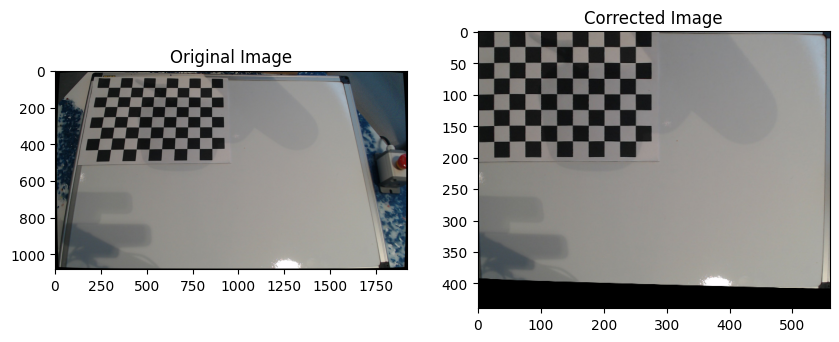

In [3]:
from ultralytics import YOLO
import cv2
from calibration.calibrate_camera import undistort_image, load_coefficients, batch_preprocess_images, preprocess_image, add_points_on_image
import matplotlib.pyplot as plt
from main import preprocess_bboxes, add_bbox_to_img
from tictactoe_engine import infer_tic_tac_toe_state, find_best_move, get_cell_center_and_shorter_edge
from xarm import version
import numpy as np
from xarm.wrapper import XArmAPI
from robotic_arm.draw import RobotMain
from robotic_arm.calculate_transformation_matrix import calculate_transformation_matrix, apply_inverse_transformation

try:
    RobotMain.pprint('xArm-Python-SDK Version:{}'.format(version.__version__))
    ARM = XArmAPI('192.168.1.159', baud_checkset=False)
    ROBOT = RobotMain(ARM)
    calibration_points = np.array([(267, 165), (251, 279)])
    transformed_points = np.array([(0, 0), (0, 120)])
    transformation_matrix = calculate_transformation_matrix(calibration_points, transformed_points)
except:
    print("yo")

ref_plan=cv2.imread("/home/fari/Pictures/calibrationcheckerboard/ref_plan.jpg")

MTX, DIST , H=  load_coefficients("calibration/calibration.yml")
CLASS_NAMES = ["O", "X", "grid"]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(undistort_image(ref_plan, MTX, DIST), cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(preprocess_image("/home/fari/Pictures/calibrationcheckerboard/ref_plan.jpg", MTX, DIST , H, width=560, height=440), cv2.COLOR_BGR2RGB))
plt.title('Corrected Image')

plt.show()  




def capture_image():
    # Initialize the webcam (0 is the default camera)
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
    # Check if the webcam is opened correctly
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return None

    # Read a frame from the webcam
    ret, frame = cap.read()

    # If frame is read correctly, ret is True
    if not ret:
        print("Error: Can't receive frame (stream end?). Exiting ...")
        return None

    # Release the webcam
    cap.release()

    return frame


0: 512x640 1 O, 1 X, 1 grid, 6.3ms
Speed: 0.8ms preprocess, 6.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict41


{'O': [[133.94203186035156, 140.62060546875, 31.240821838378906, 38.844703674316406]], 'X': [[87.50532531738281, 101.79122924804688, 28.568153381347656, 27.858619689941406]], 'grid': [[132.5584716796875, 153.20599365234375, 136.79412841796875, 179.7364501953125]]}


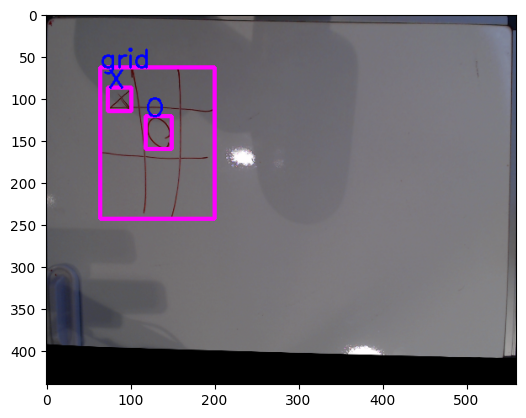

In [34]:
MODEL = YOLO("/home/fari/Documents/demo-fari-robotic-arm/vision/runs/detect/train2/weights/best.pt")
im = capture_image()
im = preprocess_image(im, MTX, DIST , H, width=560, height=440)
results = MODEL.predict(source=im, save=True) 
bboxes_dict = preprocess_bboxes(results[0].boxes, CLASS_NAMES)
im = add_bbox_to_img(im, bboxes_dict)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
print(bboxes_dict)

In [35]:
grid_state = infer_tic_tac_toe_state(bboxes_dict)
print(grid_state)
# Print the grid
for row in grid_state:
    print('|'.join(row))
    print('---------')

[['X', ' ', ' '], [' ', 'O', ' '], [' ', ' ', ' ']]
X| | 
---------
 |O| 
---------
 | | 
---------


In [36]:
move, player_letter = find_best_move(grid_state)
print(f"The best move for player {player_letter} is: {move}")
grid_state[move[0]][move[1]]=player_letter
# Print the grid
for row in grid_state:
    print('|'.join(row))
    print('---------')

The best move for player O is: (0, 2)
X| |O
---------
 |O| 
---------
 | | 
---------


(178.1565144856771, 93.29384358723958)


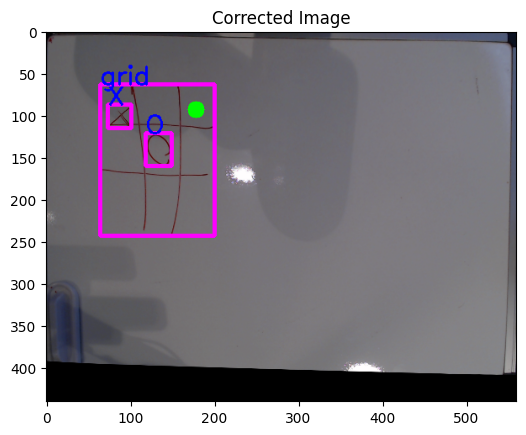

In [37]:
if not move: 
    print("game_over")
else:
    position, shortest_edge = get_cell_center_and_shorter_edge(move,bboxes_dict['grid'][0])
print(position)
img = add_points_on_image(im, [position])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Corrected Image')
plt.show()  



In [41]:
transformed_point = apply_inverse_transformation(transformation_matrix, [position[0], position[1], 1])
rest_position = apply_inverse_transformation(transformation_matrix, [0, 0, 1])
transformed_rest_position = apply_inverse_transformation(transformation_matrix, [rest_position[0], rest_position[1], 1])
print(transformed_point)
if player_letter== "X":
    ROBOT.grab_pen((191,43,24),tcp_speed=40)
    ROBOT.draw_x(transformed_point[0], transformed_point[1],  0, shortest_edge/2, rest_position=(transformed_rest_position[0],transformed_rest_position[1], 10), tcp_speed=340, tcp_acc=200)
    ROBOT.store_pen((191,43,24), rest_position=(191,0,53),tcp_speed=40)
    response = "your turn"
else:
    ROBOT.draw_o(transformed_point[0], transformed_point[1],  0, shortest_edge/2, rest_position=(rest_position[0],rest_position[1], 10), tcp_speed=30, tcp_acc=100)
    response = "your turn"



[     77.606      232.63           1]
0
[2024-02-22 11:10:50][82] set_position, code=0, connected=True, state=2, error=0, ret1=(0, 2). ret2=(0, [0, 0])


In [8]:
transformed_point = apply_inverse_transformation(transformation_matrix, [position[0], position[1], 1])
rest_position = apply_inverse_transformation(transformation_matrix, [0, 0, 1])
print(transformed_point)
"""

if player_letter== "X":
    ROBOT.draw_x(transformed_point[0], transformed_point[1],  0, 20, rest_position=(rest_position[0],rest_position[1], shortest_edge/2))
else:
    ROBOT.draw_o(transformed_point[0], transformed_point[1],  0, 20, rest_position=(rest_position[0],rest_position[1], shortest_edge/2))

    
"""
      


[     65.085      350.86           1]


'\n\nif player_letter== "X":\n    ROBOT.draw_x(transformed_point[0], transformed_point[1],  0, 20, rest_position=(rest_position[0],rest_position[1], shortest_edge/2))\nelse:\n    ROBOT.draw_o(transformed_point[0], transformed_point[1],  0, 20, rest_position=(rest_position[0],rest_position[1], shortest_edge/2))\n\n    \n'

In [22]:
position=(100,100)
rest_position = (0,0)
transformed_point = apply_inverse_transformation(transformation_matrix, [position[0], position[1], 1])
transformed_rest_position = apply_inverse_transformation(transformation_matrix, [rest_position[0], rest_position[1], 1])
ROBOT.draw_x(transformed_point[0], transformed_point[1],  0, 20, rest_position=(transformed_rest_position[0],transformed_rest_position[1], 10), tcp_speed=200, tcp_acc=100)

In [1]:



print("Transformation Matrix:\n", transformation_matrix)

point_to_transform = np.array([300, 0, 1])  # The point (-8, 270) with an added 1 for homogeneous coordinates
transformed_point = apply_inverse_transformation(transformation_matrix, point_to_transform)
print("Transformed Point:", transformed_point)

#robot_main.draw_x(transformed_point[0], transformed_point[1],  0, 20)
ROBOT.draw_o(transformed_point[0], transformed_point[1],  0, shortest_edge/2, rest_position=(rest_position[0],rest_position[1], 10), tcp_speed=10, tcp_acc=100)

NameError: name 'transformation_matrix' is not defined

In [2]:
batch_preprocess_images("/home/fari/Pictures/train", "/home/fari/Documents/demo-fari-robotic-arm/data", "calibration/calibration_coefficients.yml", width=410, height=290)

Processed image saved to /home/fari/Documents/demo-fari-robotic-arm/data/2023-10-31-161650.jpg
Processed image saved to /home/fari/Documents/demo-fari-robotic-arm/data/2023-10-31-161551.jpg
Processed image saved to /home/fari/Documents/demo-fari-robotic-arm/data/2023-10-31-161629.jpg
Processed image saved to /home/fari/Documents/demo-fari-robotic-arm/data/2023-10-31-154916.jpg
Processed image saved to /home/fari/Documents/demo-fari-robotic-arm/data/2023-10-31-155655.jpg
Processed image saved to /home/fari/Documents/demo-fari-robotic-arm/data/2023-10-31-154948.jpg
Processed image saved to /home/fari/Documents/demo-fari-robotic-arm/data/2023-10-31-154924.jpg
Processed image saved to /home/fari/Documents/demo-fari-robotic-arm/data/2023-10-31-161642.jpg
Processed image saved to /home/fari/Documents/demo-fari-robotic-arm/data/2023-10-31-154857.jpg
Processed image saved to /home/fari/Documents/demo-fari-robotic-arm/data/2023-10-31-161607.jpg
Processed image saved to /home/fari/Documents/demo

ControllerError, code: 2
[2023-10-31 16:23:38][62] err=2, quit
ControllerError, code: 2
[2023-10-31 16:23:38][69] state=4, quit
[2023-10-31 16:23:38][62] err=2, quit
[2023-10-31 16:23:38][69] state=4, quit
ControllerError had clean
ControllerError had clean
ControllerError, code: 2
ControllerError, code: 2


In [18]:
ROBOT.grab_pen((191,43,30),tcp_speed=70)
ROBOT.store_pen((191,43,30),tcp_speed=70)